In [34]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import time
import sys
sys.path.append('../')
import albumentations as A
import albumentations.pytorch
import cv2
import matplotlib.pyplot as plt


from model import Yolov1
from dataset import VOCDataset, PapsDataset, train_transforms, val_transforms
from train import Compose, train_fn
from scheduler import CosineAnnealingWarmUpRestarts

from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import YoloLoss

In [75]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
#     x_min, y_min, x_max, y_max = list(map(int, bbox))
    x_min, y_min, x_max, y_max = list(map(round, bbox))

    img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=BOX_COLOR, thickness=thickness)
    return img

def visualize(image, bboxes):
    img = image.copy()
#     img = image.clone().detach()
    for bbox in (bboxes):
#         print(bbox)
        img = visualize_bbox(img, bbox[:4])
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    
def switch_image(img) :
    h, w = img.shape[:2]
    if (h, w) == (4032, 1960) or (h, w) == (4000, 1800) :
        img = np.flip(img, 1)
        img = np.transpose(img, (1, 0, 2))      
    return img

train_transforms = A.Compose([
    A.CenterCrop(1200,1200, True,1),
    A.Resize(400, 400, p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
#     A.RandomResizedCrop(height=400,width=400,scale=[0.95,1.05],ratio=[0.95,1.05],p=0.5),
#     A.pytorch.ToTensor(),
], p=1.0, bbox_params=A.BboxParams(format='pascal_voc', min_area=0, min_visibility=0.8))    

In [28]:
partition = np.load('../data/partition.npy', allow_pickle=True, encoding='latin1').item()
label = np.load('../data/labels_info.npy', allow_pickle=True, encoding='latin1').item()

In [29]:

path

'SS2/06(201030)/20201030_095339.jpg'

In [30]:
label[path]

[[1990, 989, 2104, 1082, 1.0]]

(4032, 1960, 3)
(1960, 4032, 3)


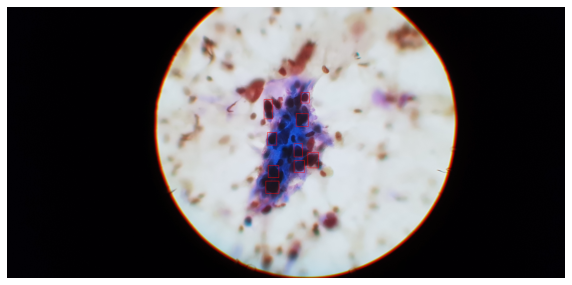

In [44]:
path = partition['train'][8]
image = cv2.imread('/home/Dataset/Papsmear/original/' + path)
print(image.shape)
image = switch_image(image)
print(image.shape)
bbox = label[path]
visualize(image, bbox)

(400, 400, 3)


[(238.66666666666669,
  63.66666666666667,
  285.33333333333337,
  102.66666666666669,
  1.0)]

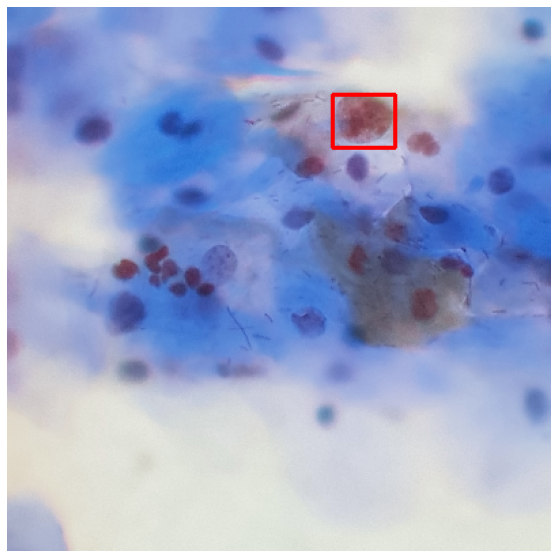

In [79]:
path = partition['train'][65]
image = cv2.imread('/home/Dataset/Papsmear/original/' + path)
image = switch_image(image)
bbox = label[path]
transformed = train_transforms(image=image, bboxes=bbox)
transformed_image = transformed['image']
print(transformed_image.shape)
transformed_bboxes = transformed['bboxes']
visualize(transformed_image, transformed_bboxes)
transformed_bboxes

In [88]:
boxes = transformed_bboxes
boxes = torch.tensor(boxes)
print(transformed_bboxes)
boxes[:,2] = (boxes[:,2] - boxes[:,0])/2
boxes[:,3] = (boxes[:,3] - boxes[:,1])/2
boxes[:,0] = boxes[:,0] + boxes[:,2]
boxes[:,1] = boxes[:,1] + boxes[:,3]
print(boxes)
boxes[:,:4] = boxes[:,:4]/transformed_image.shape[1]
print(boxes)
transformed_image.shape

[(238.66666666666669, 63.66666666666667, 285.33333333333337, 102.66666666666669, 1.0)]
tensor([[262.0000,  83.1667,  23.3333,  19.5000,   1.0000]],
       dtype=torch.float64)
tensor([[0.6550, 0.2079, 0.0583, 0.0488, 1.0000]], dtype=torch.float64)


(400, 400, 3)

In [90]:
S=25
C=1
B=2
label_matrix = torch.zeros((S, S, C + 5 * B))
for box in boxes:
    x, y, width, height, class_label = box.tolist()
    print(x, y, width, height, class_label)
#             class_label = int(class_label)
    class_label = 0
    # i,j represents the cell row and cell column
    i, j = int(S * y), int(S * x)
    x_cell, y_cell = S * x - j, S * y - i
    print(i, j)
    print(x_cell, y_cell)
    width_cell, height_cell = (
        width * S,
        height * S,
    )    
    print(width_cell, height_cell)

0.655 0.20791666666666672 0.058333333333333355 0.048750000000000016 1.0
5 16
0.375 0.19791666666666785
1.458333333333334 1.2187500000000004
